In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
from matplotlib import animation
from matplotlib import cm
import os,sys
sys.path.append('/Users/ajc/Core/PyScript')
import readdata as rd
import os
import geopy.distance
import utm

In [2]:
#mesh_resfile= '/Users/ajc/Core/simulations/production/streams/SIM_14/mesh_coords_10m_250min/ats_vis_surface_mesh.h5'
#mesh_hres = rd.get_mesh_coords(mesh_resfile)
#NOTE: high resolution mesh needs to be merged as well (merge is based on reaches not on cells size) to get the
# correct id of the reach when mapping coarse resolution mesh onto it

In [3]:
infile ='/Users/ajc/Core/PreProcessing/ReactiveTransport/data/portage_river/'
outfile='/Users/ajc/Core/PostProcessing/ReactiveTransport/2021/Q2/'

In [4]:
#Coarse scale simulation
dx, dx_min = 500, 250 
sim = 'S2_BGC_dx%sm_min%sm'%(dx,dx_min)
sim_mesh= ''
path='/Users/ajc/Core/simulations/production/streams/SIM_14/%s'%sim

infile_sim = [os.path.join(path,'ats_vis_surface_data.h5'), os.path.join(path,'ats_vis_surface_mesh.h5') ]

In [5]:
#Simulation mesh resolution
mesh = rd.get_mesh_coords(infile_sim[1])

In [6]:
# Read simulation data
variables = [(0,'DOM1'), (1,'O2(aq)'), (2,'NO3-'), (3,'HCO3-'),(4,'H+'), (5,'N2(aq)')]
var_c = 2
var = variables[var_c][0]
C_data = rd.GetSurfVarFromVis_All(infile_sim[0],'surface-total_component_concentration',suffix='.cell.%s'%var)
Concentration = C_data['surface-total_component_concentration']
cycles = len(Concentration)
print (cycles, len(Concentration[0]), Concentration[0][0])

5761 1152 0.05


In [7]:
# Get number of cells per reach in the coarse scale simulation
C = Concentration[0] #np.arange(1,len(Concentration[0]), 1)
sim_cells_file = np.loadtxt(os.path.join(infile,'reach_cells/vector_cells-500m_min250m.dat'),usecols=0,delimiter=',')
sim_cells_file = np.array(sim_cells_file,dtype=int)
print (len(sim_cells_file))
def get_cres_cells(sim_cells_file):
    csum = np.cumsum(sim_cells_file)
    for c in csum:
        yield c

285


In [8]:
# these are the cells they were merged, but we keep a history of them (in the 2nd column) for visulation 
# otherwise (not always) we see vis artifacts resulting in disconnected streams

cellsmerged_file = np.loadtxt(os.path.join(infile,'reach_cells/vector_cells-10m_min250m.dat'),usecols=1,delimiter=',')
cellsmerged_file = np.array(cellsmerged_file,dtype=int)
        
def get_hres_cells(cellsmerged_file):
    csum = np.cumsum(cellsmerged_file)
    for c in csum:
        yield c

In [9]:
# High resolution data (centriods) for visulization (coarse data map onto this resolution)
mesh_hresC = dict()
cent_file = np.loadtxt(os.path.join(infile,'centroids/centriods_merged-10m_min250mA.dat'),usecols=(0,1),delimiter=',')
mesh_hresC['x'] = np.array(cent_file[:,0],dtype=float)
mesh_hresC['y'] = np.array(cent_file[:,1],dtype=float)
#print (mesh_hresC['x'], len(mesh_hresC['x']))

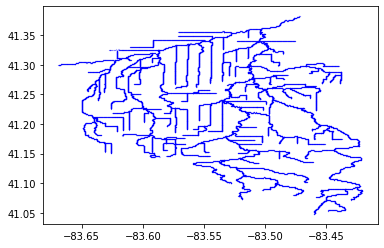

In [10]:
plt.scatter(mesh_hresC['x'],mesh_hresC['y'], s=0.01, c='b')

In [11]:
def get_mapped_data(C):
    p_mesh_res = get_hres_cells(cellsmerged_file)
    p_mesh_sim = get_cres_cells(sim_cells_file)
    xprev1, xprev2 = 0, 0
    C_new = []
    C_consumption = []
    meshx = []
    meshy = []
    i = 0
    c_x = 0
    cc = 0
    for it1, it2 in zip(p_mesh_res,p_mesh_sim):
        l1 = len(C[xprev2:it2])
        l1 = 1 if l1 ==0 else l1
        l2 = int((it1 - xprev1)/(it2 -xprev2))
        C_temp = np.zeros((l1,l2))
        for i in range(l1):
            C_temp[i] = C[xprev2:it2][i]
            
        c_x = c_x + it2 -xprev2
        
        for c in C_temp:
            C_new.append(c)
            C_consumption.append(C_temp[-1] - C_temp[0])
          
        C_new1 = [c for x in C_new for c in x]
        r = (it1  - len(C_new1))
        for i1 in range(r):
            C_new.append([C_new[-1][0]])
        C_new1 = [c for x in C_new for c in x]
        xprev1 = it1
        xprev2 = it2
    C_new = [c for x in C_new for c in x]
    C_consumption = [c for x in C_consumption for c in x]
    print ('LL: ',len(C_new), c_x)
    #print (C_new)
    return C_new, C_consumption

In [ ]:
#C_new1= get_mapping(C)
#C_new1= get_mapping(Concentration[5100])


Dist:  28.093703833469952 41.37607023334934


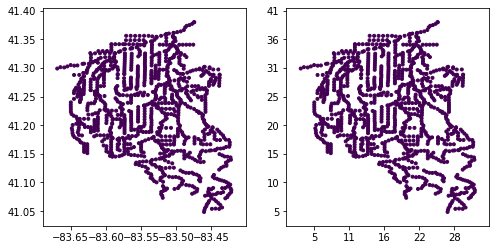

In [12]:
#%matplotlib qt
def get_limits():
    fig, ax = plt.subplots(1,2,figsize=(8,4))#,subplot_kw={"projection": "3d"})
    
    ax[0].scatter(mesh['x'],mesh['y'],marker=".",c=mesh['z'])
    
    #xmin, xmax = ax[0].get_xlim() 
    #ymin, ymax = ax[0].get_ylim()
    tol = 0.0
    xmin, ymin = -83.67031351227165 - tol, 41.026924124827296
    xmax, ymax = -83.41875747941427 + tol, 41.399486735207795
    
    xx = geopy.distance.geodesic(xmin,xmax).km #+ 0.07
    yy = geopy.distance.geodesic(ymin,ymax).km #+ 0.455
    Xlabels = np.round(np.linspace(0,xx,6,dtype=int),2)
    print ('Dist: ', xx,yy)
    Ylabels = np.round(np.linspace(0,yy,9,dtype=int),2)
    
    ax[1].scatter(mesh['x'],mesh['y'],marker=".",c=mesh['z'])
    ax[1].set_xticklabels(Xlabels)
    ax[1].set_yticklabels(Ylabels)
    #ax[1].set_xlim(xmin,xmax)
    #ax[1].set_ylim(ymin,ymax)
    
    #plt.gca().invert_xaxis()
    plt.show()
    X0 = [xmin, xmax]
    Y0 = [ymin, ymax]
    return X0, Y0, Xlabels, Ylabels
    
X0, Y0, Xlabels,Ylabels = get_limits()

In [13]:
outfile='/Users/ajc/Core/PostProcessing/ReactiveTransport/2021/Q2/PR/'

LL:  51478 1152
Max1:  418.8698518882232 84.90304678613643
Lengths:  51478 51478


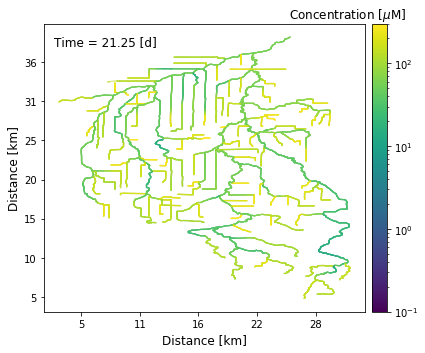

In [14]:
#Write solute concentration images to a directory
#%matplotlib qt
centroid = []
thick = [1,1,1]
count = 0

time = [np.round(t*360/86400,2) for t in range(cycles)]
RR = []
to_micro = 1e+6
start = 5100#200
end = start + 1
for k in range(start,cycles,1):
    var = variables[var_c][1]
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    ran = Concentration[k]
    
    ran = np.array([r*1e-3*to_micro if r>0 else 1e-12 for r in ran])
    C_up, C_con = get_mapped_data(ran)
    
    print ('Max1: ', np.max(C_up), np.max(C_con))
    print ("Lengths: ", len(mesh_hresC['x']), len(C_up))
    l_max = 300
    l1,l2=0,-1
    
    #sc = ax.scatter(mesh_new['x'][l1:l2],mesh_new['y'][l1:l2],marker=".",c=C_up[l1:l2],s=.1, cmap=plt.get_cmap('viridis'), vmin=1e-1,vmax=l_max,norm=matplotlib.colors.LogNorm()) # mesh resolution
    sc = ax.scatter(mesh_hresC['x'][l1:l2],mesh_hresC['y'][l1:l2],marker=".",c=C_up[l1:l2],s=.1, cmap=plt.get_cmap('viridis'), vmin=1e-1,vmax=l_max,norm=matplotlib.colors.LogNorm()) # mesh resolution
    #ax.scatter(mesh['x'][l1x:l2x],mesh['y'][l1x:l2x],marker=".",c=ran[l1x:l2x],s=10, cmap=plt.get_cmap('viridis'), vmin=1e-1,vmax=l_max,norm=matplotlib.colors.LogNorm()) # mesh resolution
    
    ax.text(mesh['x'][-1]-0.16,mesh['y'][-1]+0.025, 'Time = %s [d]'%time[k],fontsize=12,fontstyle='normal')
    cb = plt.colorbar(sc,pad=0.02,fraction=0.046)
    cb.ax.set_ylabel(r'Concentration [$\mu$M]',labelpad=-70, y=1.06,rotation=0,fontsize=12)

    #ax.set_xlim(X0)
    #ax.set_ylim(Y0)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xticklabels(Xlabels)
    ax.set_yticklabels(Ylabels)
    ax.set_xlabel('Distance [km]',fontsize=12, fontweight='normal')
    ax.set_ylabel('Distance [km]',fontsize=12, fontweight='normal')
    plt.tight_layout(h_pad=1)
    #plt.gca().invert_xaxis()
    #plt.text(X_mesh[-1]-0.02,Y_mesh[-1]+0.025, 'Time [hr] = %s'%time[k])
    
    
    #plt.savefig(outfile + 'fig2D-%sC.png'%(sim),dpi=200)
    
    count =1 + k
    if count == end:
        break
    plt.close()
#print (l_max)

In [ ]:
#l1,l2=36,37#x
#l1,l2=63,64
#l1,l2=92,93
#l1,l2=170,171 #x
#l1,l2=192,193
#l1,l2=228,229
#sc = ax.scatter(mesh['x'][l1:l2],mesh['y'][l1:l2],marker="*",c='r',s=10, cmap=plt.get_cmap('viridis'))#, vmin=1,vmax=l_max)#,norm=matplotlib.colors.LogNorm()) # mesh resolution

#sc = ax.scatter(X_mesh[ss:],Y_mesh[ss:],marker=".",c=ran[ss:],cmap=plt.get_cmap('jet'),vmin=1.e-6,vmax=l_max,norm=matplotlib.colors.LogNorm())



In [ ]:
import colormap as cp
c = cp.Colormap()
mycmap = c.cmap_linear('blue', 'green', 'yellow')
#map = c.test_colormap(mycmap)
from matplotlib import cm

top = cm.get_cmap('hsv', 256)
bot = cm.get_cmap('viridis', 128)
from matplotlib.colors import ListedColormap
nn = np.vstack((  bot(np.linspace(0.5,1.0,128)), top(np.linspace(0.3,0.1,128)))) 
#mycmap = ListedColormap(nn)
mycmap = ListedColormap(top(np.linspace(0.65,0.12,256)))
mycmap = ListedColormap(top(np.linspace(0,1,256)))